# Task5:Decision Trees and Random Forests

#### 1.Importing the dataset,splitting and preprocessing

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [137]:
data=pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [138]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [139]:
X = data.drop(columns=['target'], axis=1)
y=data['target']

In [140]:
X.shape,y.shape

((1025, 13), (1025,))

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [142]:
# Standardization
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = list(set(X.columns) - set(continuous_features))


In [143]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#### 2.Training the Decision tree classifier and visualizing

In [144]:
#training the decision tree classifier
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [145]:
tree_clf = DecisionTreeClassifier(
    max_depth=3,  
    random_state=42
)
tree_clf.fit(X_train_processed, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

In [146]:
feature_names = (continuous_features + categorical_features)

In [147]:
# Generating Graphviz visualization
dot_data = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=feature_names,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
    impurity=False
)



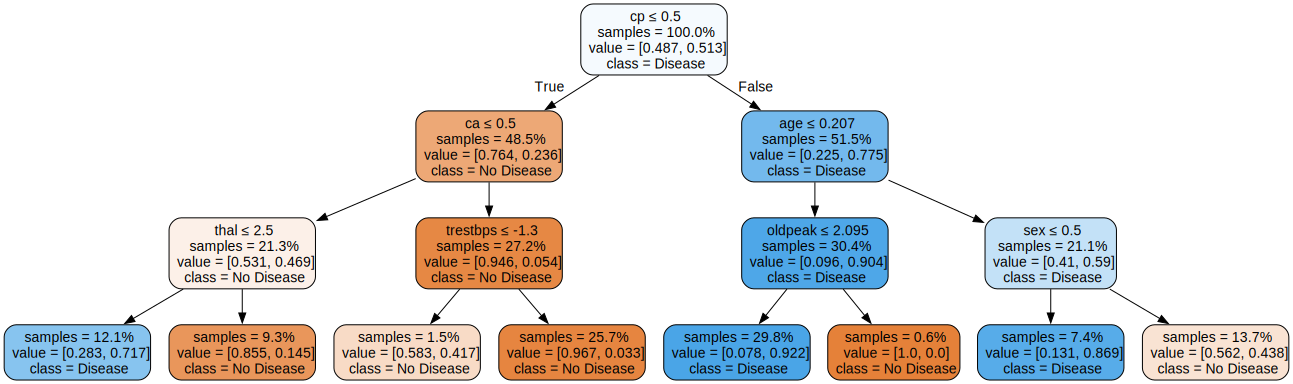

In [148]:
graph = graphviz.Source(dot_data)
graph.render("heart_disease_tree", format='png', cleanup=True) 
graph 

#### 3.Analyzing overfitting and controlling tree depth

In [149]:
from sklearn.metrics import accuracy_score

In [150]:
depths = list(range(1, 21))
train_acc = []
test_acc = []

In [151]:
for depth in depths:
    tree = DecisionTreeClassifier(
        max_depth=depth,
        random_state=42
    )
    tree.fit(X_train_processed, y_train)
    

    train_acc.append(accuracy_score(y_train, tree.predict(X_train_processed)))
    test_acc.append(accuracy_score(y_test, tree.predict(X_test_processed)))

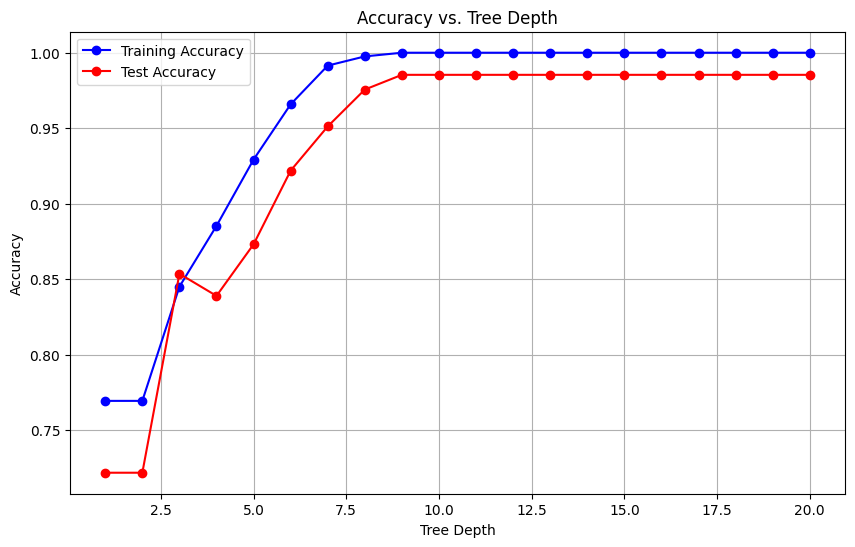

In [152]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(depths, train_acc, 'bo-', label='Training Accuracy')
plt.plot(depths, test_acc, 'ro-', label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.legend()
plt.grid(True)
plt.savefig('tree_depth_analysis.png', dpi=300)
plt.show()

In [153]:
#After evaluating the treeclf optimal will be created as
optimal_tree = DecisionTreeClassifier(
    max_depth=5,            
    min_samples_split=20,     
    min_samples_leaf=10,      
    max_features='sqrt',      
    ccp_alpha=0.01,           
    random_state=42
)

optimal_tree.fit(X_train_processed, y_train)

# Evaluating
train_acc = optimal_tree.score(X_train_processed, y_train)
test_acc = optimal_tree.score(X_test_processed, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.7793
Test Accuracy: 0.7463


#### 4.Training a random forest and comparing accuracy

In [154]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=100,         
    max_depth=5,              
    min_samples_split=20,     
    min_samples_leaf=10,      
    max_features='sqrt',      
    random_state=42
)
rf_clf.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [155]:
# Evaluating Random Forest
rf_train_acc = rf_clf.score(X_train_processed, y_train)
rf_test_acc = rf_clf.score(X_test_processed, y_test)

#comparing with Decision Tree
print(f"Random Forest Training Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

print(f"Decision Tree Training Accuracy: {train_acc:.4f}")
print(f"Decision Tree Test Accuracy: {test_acc:.4f}")

Random Forest Training Accuracy: 0.9134
Random Forest Test Accuracy: 0.8976
Decision Tree Training Accuracy: 0.7793
Decision Tree Test Accuracy: 0.7463


#### 5.Interpreting feature importance

     Feature  Importance
4    oldpeak    0.394288
12        cp    0.325318
9         ca    0.185112
8      slope    0.048457
0        age    0.046826
1   trestbps    0.000000
2       chol    0.000000
3    thalach    0.000000
5        sex    0.000000
6       thal    0.000000
7        fbs    0.000000
10     exang    0.000000
11   restecg    0.000000


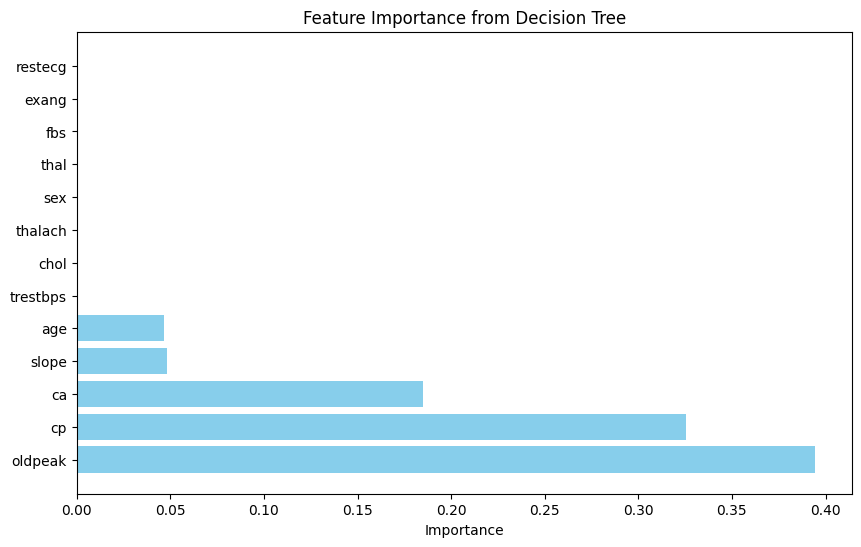

In [156]:
# Feature importance for the optimal decision tree
importances = optimal_tree.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plotting feature importance for decision tree
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Decision Tree')
plt.savefig('feature_importance.png', dpi=300)
plt.show()


     Feature  Importance
12        cp    0.176030
6       thal    0.159429
9         ca    0.155372
4    oldpeak    0.118053
10     exang    0.103290
3    thalach    0.086195
0        age    0.057951
8      slope    0.045180
2       chol    0.033259
1   trestbps    0.027788
5        sex    0.025063
11   restecg    0.011210
7        fbs    0.001181


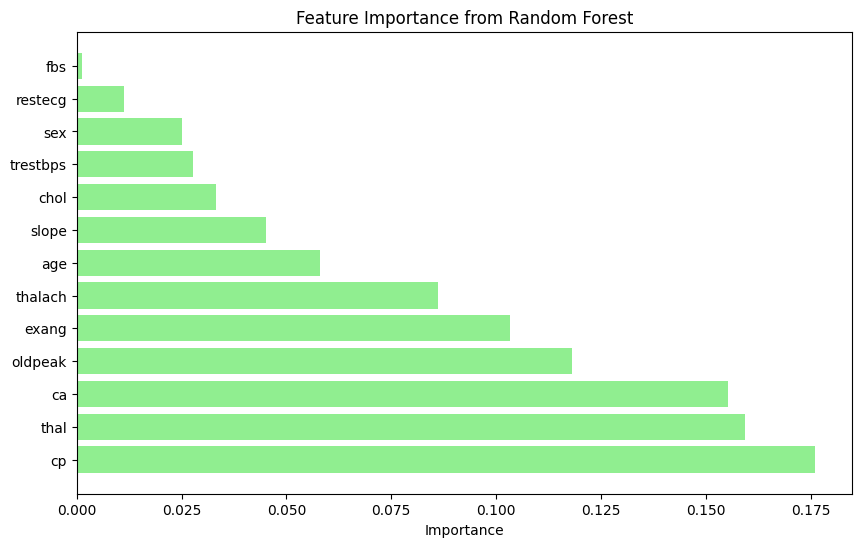

In [157]:
# Feature importance for the random forest classifier
rf_importances = rf_clf.feature_importances_
rf_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)
print(rf_feature_importance_df)

# Plotting feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()


#### 6.Evaluating using Cross validation

In [158]:
#Evaluating optimal tree using cross validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(
    optimal_tree, 
    X_train_processed, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation Scores: [0.81097561 0.79268293 0.79268293 0.78658537 0.80487805]
Mean CV Accuracy: 0.7976 ± 0.0090


In [159]:
# Evaluating Random Forest using cross-validation
rf_cv_scores = cross_val_score(
    rf_clf, 
    X_train_processed, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)
print(f"Random Forest Cross-Validation Scores: {rf_cv_scores}")
print(f"Mean Random Forest CV Accuracy: {np.mean(rf_cv_scores):.4f} ± {np.std(rf_cv_scores):.4f}")


Random Forest Cross-Validation Scores: [0.87195122 0.87195122 0.90243902 0.89634146 0.84756098]
Mean Random Forest CV Accuracy: 0.8780 ± 0.0197
